# Drinkwaterwinning Bleijerheide

## Inladen Python pakketten

In [23]:
def plot_resultaat(observation, prediction, path=None, title=None):
    Path(path).parents[0].mkdir(exist_ok=True, parents=False)
    fig, ax = plt.subplots(1,1,figsize=(14,4))
    ax.plot(prediction.index, prediction['P_pred'], 'orange', linestyle='-', zorder=1, label='P_pred')
    ax.plot(observation.index, observation['P'], zorder=0, label='P')
    plt.xlabel('Datum')
    plt.legend()
    plt.grid(True)
    ax.set_xlim(prediction.index[0], prediction.index[-1])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(path, dpi=100, transparent=False)
    

In [24]:
We plotten zowel de gemeten als de voorspelde neerslag...

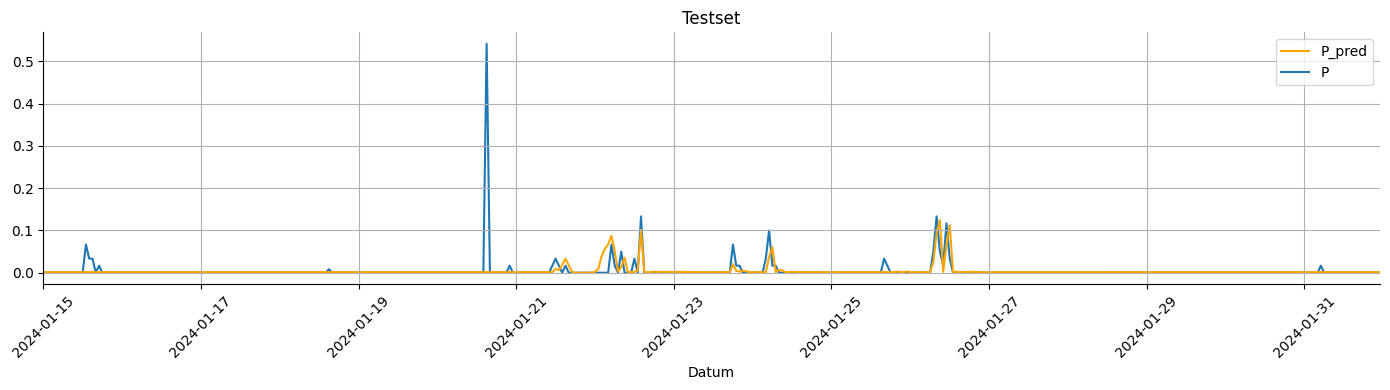

In [25]:
plot_resultaat(Y_test, y_hat, path='figuren_model/resultaat_testset.png', title='Testset')

... en schrijven ook het resultaat naar csv.

In [21]:
output = pd.concat([y_hat, Y_test], axis=1, ignore_index=False)
Path('tabellen_model').mkdir(parents=False, exist_ok=True)
output.to_csv(r'tabellen_model/resultaat_testperiode.csv', sep=",")

In deze periode blijkt een neerslagpiek te zijn geweest die geen relatie heeft met de afvoer - het model kan deze dus ook niet voorspellen. 

## Resultaten validatieperiode

Nu doen we hetzeldfde met de validatieperiode:

35/35 [==============================] - 0s 946us/step


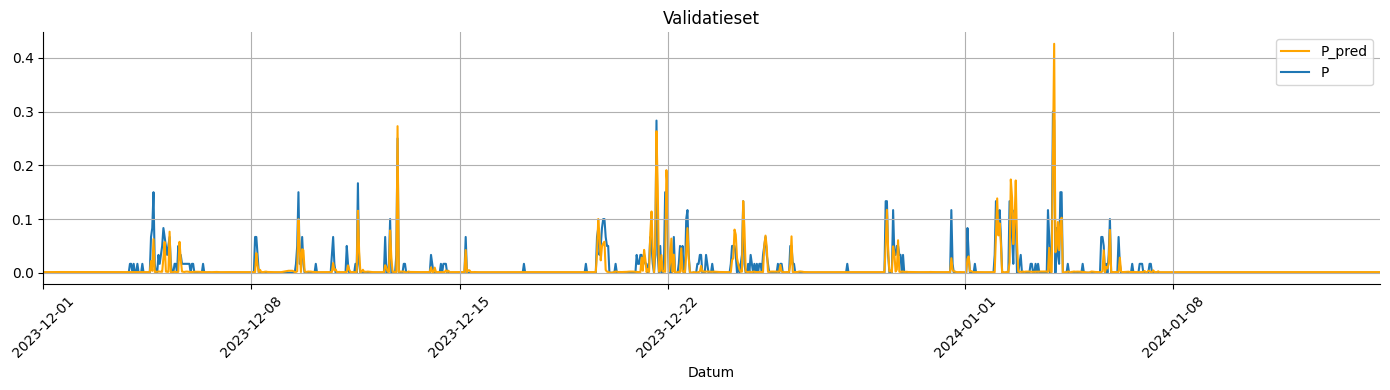

In [23]:
# inladen features
X_val = pd.read_csv('data/X_val_scaled_new.csv', index_col=0, parse_dates=True)

# inladen target
Y_val = pd.read_csv('data/Y_val_new.csv', index_col=0, parse_dates=True)

# maak voorspelling
y_val_hat = pd.DataFrame(index=X_val.index, data=model.predict(X_val), columns=['P_pred'])
y_val_hat[y_val_hat['P_pred'] < 0] = 0

# plot 
plot_resultaat(Y_val, y_val_hat, path='figuren_model/resultaat_validatieset.png', title="Validatieset")

In [25]:
output = pd.concat([y_val_hat, Y_val_test], axis=1, ignore_index=False)
Path('tabellen_model').mkdir(parents=False, exist_ok=True)
output.to_csv(r'tabellen_model/resultaat_validatieperiode.csv', sep=",")

NameError: name 'Y_val_test' is not defined

### Selectie met start- en einddatum

In [27]:
def select_daterange(df, start_date, end_date):
    """
    Returns a DataFrame with only the rows between the start and end date.
    """
    mask = (df.index >= start_date) & (df.index < end_date)
    df_selected = df.loc[mask]
    return df_selected

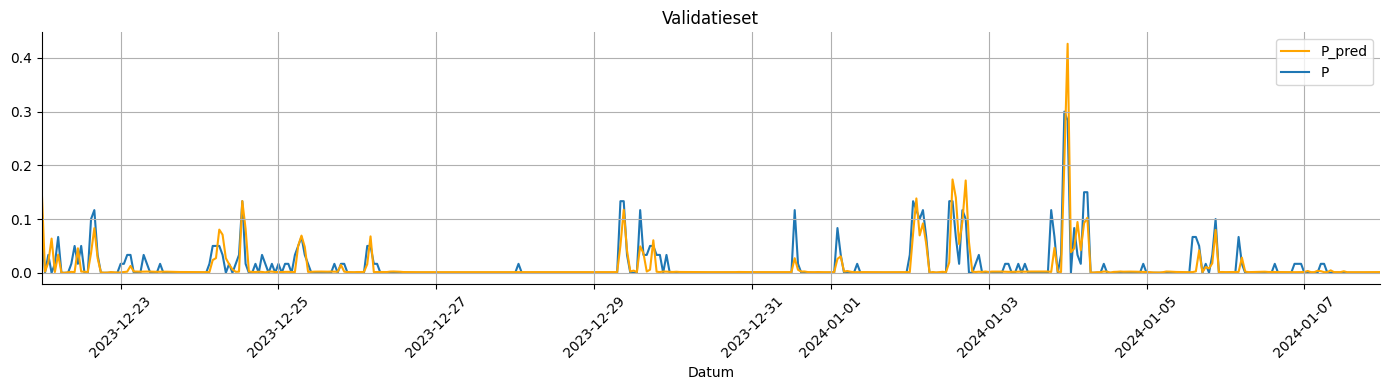

In [30]:
# kies startdatum 
start_date = pd.to_datetime('2023-12-22')

# kies einddatum
end_date = pd.to_datetime('2024-01-08')

plot_resultaat(select_daterange(Y_val, start_date, end_date), select_daterange(y_val_hat, start_date, end_date), path=f"resultaat_validatieset_van_{start_date.strftime('%Y%m%d')}_tot_{end_date.strftime('%Y%m%d')}.png", title="Validatieset")

In [ ]:
start_date